In [1]:
####In this project, we attempt to forecast the CO2 emmissions of a city from an existing dataset using SARIMA model.
###FOr more info, see https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
##First import modules and set styles
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('fivethirtyeight')

##Then import the data from Seaborn Datasets
data = sm.datasets.co2.load_pandas()
y = data.data

In [2]:
##Our forecasts will be based on the monthly mean of the emissions and resampled to the first day of each month
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

##To eliminate missing values, we will backfill missing values
# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


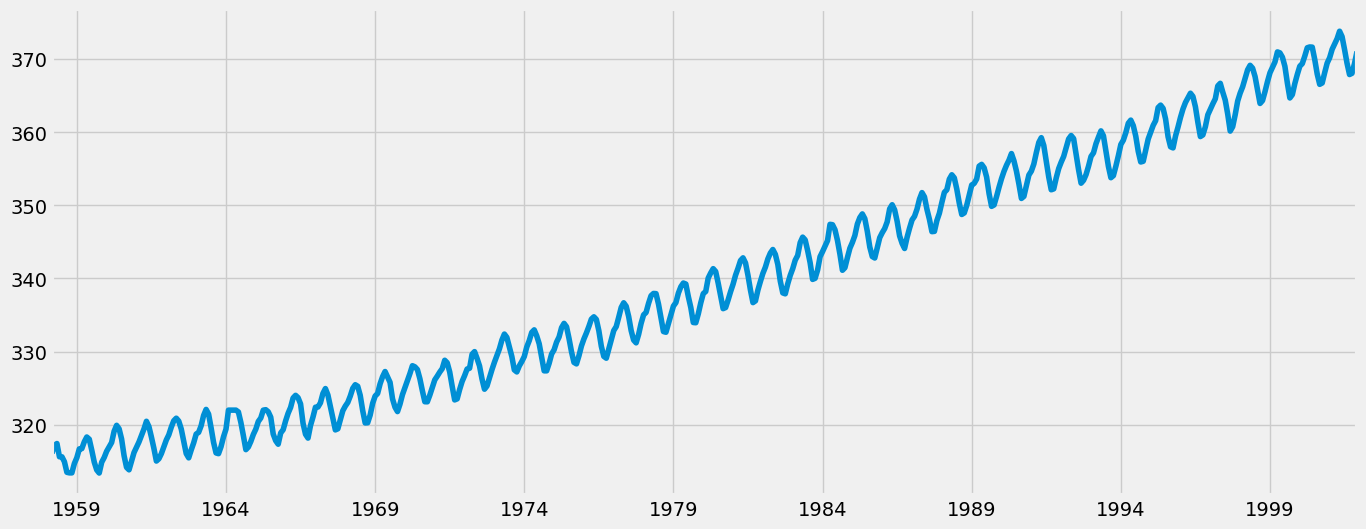

In [3]:
y.plot(figsize=(15, 6))
plt.show()

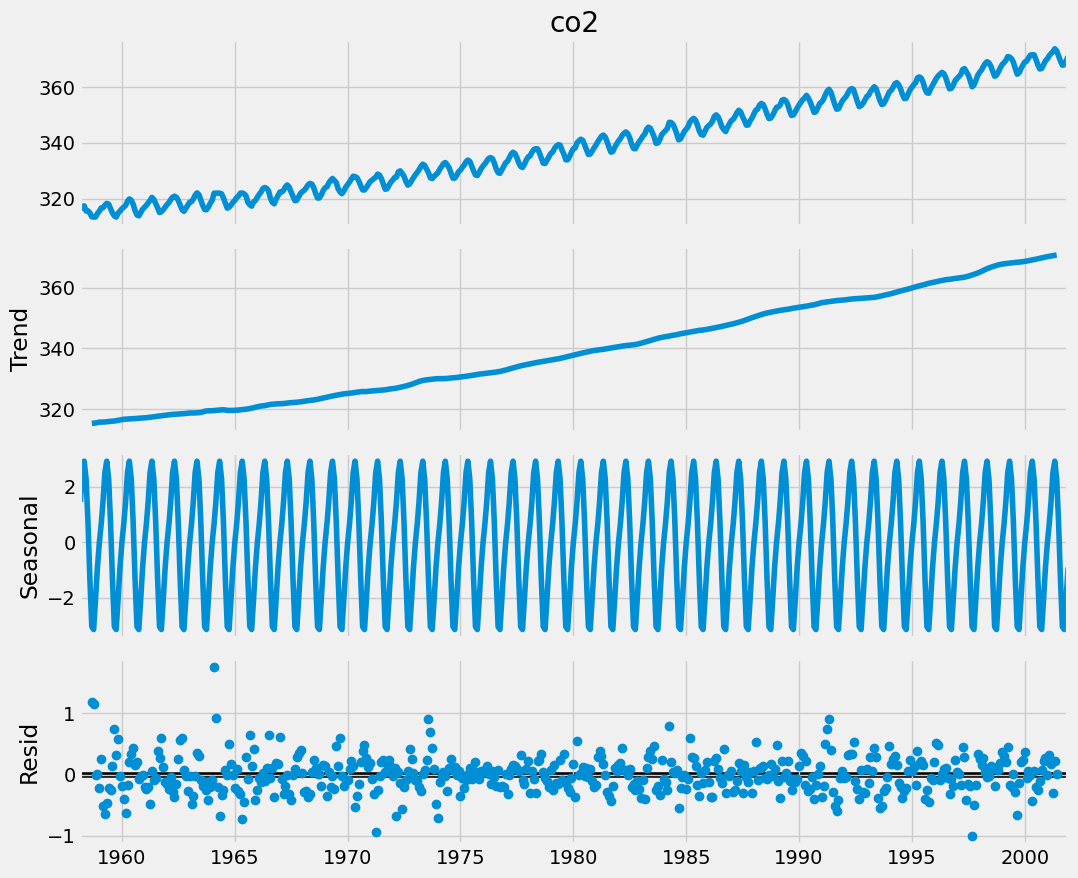

In [21]:
##Having plotted the data, we observe that it has an upward trend and is seasonal 
##We can therefore attempt to decompose the plot into its trend, seasonal and residuals.
##Since the seasonal component is largely unchanged, we can assume additive decomposition

rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [5]:
#Selecting the ARIMA model parameters p,d,q and P,D,Q,S

#From the plot, the seasons repeat every 12 months, so S = 12
#We want to get the best values of p,d and q, so we pick arbitrary values between a range and iterate through the combination of parameters
#We then evaluate each model and determine its Akaik Information Criterion (AIC) score
#The model with the lowest AIC score is the best model
#Here, our range is 0,2

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
print(seasonal_pdq)
print(pdq)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [8]:
#To automate this process, we create a DataFrame to hold the parameters and AIC scores.
#The best model is then selected from the dataframe of results

#Define the dataframe
aic_list=pd.DataFrame(columns=["pdq","seasonal_pdq", "aic"])

#Iterate through each combination of p,q,d x P,Q,D,S and store in the dataframe

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            param_aic = pd.DataFrame(data = [[param, param_seasonal, results.aic]], columns=["pdq","seasonal_pdq", "aic"])
            
            aic_list = pd.concat([param_aic,aic_list])
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23439D+00    |proj g|=  7.59925D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.599D-07   7.234D+00
  F =   7.2343948953241553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69608D+00    |proj g|=  6.13655D-01

At iterate    5    f=  1.51399D+00    |proj g|=  3.00342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   4.409D-07   1.514D+00
  F =   1.5139840045286244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172764113
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     37      1     0     0   4.450D-02   9.984D-01
  F =  0.99837248005109269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878490137496
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29055D+00    |proj g|=  1.17844D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  9.89316D-01    |proj g|=  2.30203D-01

At iterate   15    f=  9.87419D-01    |proj g|=  4.80977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   4.810D-05   9.874D-01
  F =  0.98741900315052766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.764791314355
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11368D+00    |proj g|=  6.58691D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.61982D+00    |proj g|=  2.62308D-03

At iterate   15    f=  6.61728D+00    |proj g|=  3.23835D-02

At iterate   20    f=  6.45871D+00    |proj g|=  5.98644D-01

At iterate   25    f=  5.78205D+00    |proj g|=  4.10937D-01

At iterate   30    f=  5.76679D+00    |proj g|=  3.00423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     61      1     0     0   2.200D-05   5.767D+00
  F =   5.7667892848117210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327621931
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716808352
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88954D+00    |proj g|=  7.21398D-01

At iterate    5    f=  6.58167D+00    |proj g|=  1.30689D-02

At iterate   10    f=  6.57881D+00    |proj g|=  1.23847D-01

At iterate   15    f=  3.46614D+00    |proj g|=  7.98017D+01

At iterate   20    f=  2.26979D+00    |proj g|=  1.03341D+02

At iterate   25    f=  1.75106D+00    |proj g|=  5.52160D+01

At iterate   30    f=  1.32164D+00    |proj g|=  5.94357D+01


 This problem is unconstrained.



At iterate   35    f=  1.19389D+00    |proj g|=  3.59819D+01

At iterate   40    f=  1.09090D+00    |proj g|=  2.52832D+01

At iterate   45    f=  1.05257D+00    |proj g|=  1.55941D+01

At iterate   50    f=  1.03252D+00    |proj g|=  3.95357D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50    118      1     0     0   3.954D+00   1.033D+00
  F =   1.0325246409795148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1092.2159223104495
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



At iterate   15    f=  6.52694D+00    |proj g|=  1.09130D-01
  ys=-2.652E+00  -gs= 7.751E-01 BFGS update SKIPPED

At iterate   20    f=  4.47066D+00    |proj g|=  1.33984D+01
  ys=-5.614E-01  -gs= 8.149E-01 BFGS update SKIPPED

At iterate   25    f=  3.59192D+00    |proj g|=  9.04574D+00

At iterate   30    f=  1.48972D+00    |proj g|=  7.37056D+01

At iterate   35    f=  7.82423D-01    |proj g|=  7.02919D+01

At iterate   40    f=  7.34397D-01    |proj g|=  1.96154D-02

At iterate   45    f=  7.34298D-01    |proj g|=  1.05004D+00

At iterate   50    f=  7.34250D-01    |proj g|=  1.71522D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893610348
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38037D+00    |proj g|=  8.40437D-01

At iterate    5    f=  8.24061D-01    |proj g|=  2.82786D-01

At iterate   10    f=  7.62148D-01    |proj g|=  1.17453D-01

At iterate   15    f=  7.59593D-01    |proj g|=  1.48026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     31      1     0     0   3.510D-06   7.596D-01
  F =  0.75959248943669455     

CONVERGENCE: 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.79385481881
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54470D-01    |proj g|=  2.69453D-01

At iterate    5    f=  3.17359D-01    |proj g|=  5.16139D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     17      1     0     0   7.553D-06   3.173D-01
  F =  0.31729453880115022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      5      1     0     0   3.858D-05   4.509D-01
  F =  0.45088373644168911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:478.32969073665697
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62371D-01    |proj g|=  2.18977D-01

At iterate    5    f=  3.16301D-01    |proj g|=  2.58139D-01


 This problem is unconstrained.



At iterate   10    f=  3.01889D-01    |proj g|=  1.73096D+00

At iterate   15    f=  3.01405D-01    |proj g|=  2.96388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     55      1     0     0   4.798D-03   3.014D-01
  F =  0.30140458555489130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:323.07762400374565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43891D+00    |proj g|=  1.95608D+00

At iterate   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:587.9479710477509
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52013D-01    |proj g|=  8.36236D-01


 This problem is unconstrained.



At iterate    5    f=  2.85305D-01    |proj g|=  3.64860D-01

At iterate   10    f=  2.81840D-01    |proj g|=  1.42595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     22      1     0     0   4.210D-05   2.818D-01
  F =  0.28183925868295212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:302.49490013446564
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37809D+00    |proj g|=  2.28191D+00

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:584.4333533187419
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24872D+00    |proj g|=  2.24405D+00

At iterate    5    f=  6.90114D-01    |proj g|=  3.51919D+00

At iterate   10    f=  3.74006D-01    |proj g|=  2.47340D-01

At iterate   15    f=  3.27914D-01    |proj g|=  4.03566D-01

At iterate   20    f=  3.12928D-01    |proj g|=  1.05227D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   4.273D-

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.05976D-01    |proj g|=  1.15754D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   1.158D-06   4.060D-01
  F =  0.40597562814589666     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:433.08636080948327
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53731D-01    |proj g|=  8.34383D-01

At iterate    5    f=  2.80420D-01    |proj g|=  4.65728D-01

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   25    f=  2.59999D-01    |proj g|=  5.41878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     80      2     1     0   5.419D-03   2.600D-01
  F =  0.25999905282251135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.51900356928195
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59020D+00    |proj g|=  4.07098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62985D-01    |proj g|=  4.22032D-01

At iterate    5    f=  3.48217D-01    |proj g|=  4.09515D-01

At iterate   10    f=  3.18783D-01    |proj g|=  2.82517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     22      1     0     0   9.889D-06   3.187D-01
  F =  0.31871640825101688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:341.28966148006975
RUNNING THE L-

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  4.60117D-01    |proj g|=  9.37221D+00

At iterate   15    f=  4.35484D-01    |proj g|=  1.20141D+00

At iterate   20    f=  4.28695D-01    |proj g|=  1.32841D+00

At iterate   25    f=  3.46572D-01    |proj g|=  4.32184D+00

At iterate   30    f=  3.44669D-01    |proj g|=  2.66026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     59      1     0     0   2.660D-02   3.447D-01
  F =  0.34466893437178142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:370.5917189591141
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.39781D-01    |proj g|=  1.23505D+00

At iterate   10    f=  3.15204D-01    |proj g|=  1.89036D-01

At iterate   15    f=  3.04548D-01    |proj g|=  1.23989D+00

At iterate   20    f=  3.03786D-01    |proj g|=  1.77271D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   1.668D-05   3.038D-01
  F =  0.30378408714664168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:327.580859678267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.35526D+00    |proj g|=  6.37256D+00

At iterate   10    f=  1.34955D+00    |proj g|=  1.77187D+00

At iterate   15    f=  1.31900D+00    |proj g|=  3.39752D+01

At iterate   20    f=  1.29950D+00    |proj g|=  4.04779D+00
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1372.6085881677725

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     42      1     0     0   6.888D-02   1.299D+00
  F =   1.2990575933153732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05799D-01    |proj g|=  1.26889D+00

At iterate   10    f=  2.83071D-01    |proj g|=  1.00720D-01

At iterate   15    f=  2.82957D-01    |proj g|=  8.82735D-02

At iterate   20    f=  2.82916D-01    |proj g|=  9.24572D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   9.246D-06   2.829D-01
  F =  0.28291576405033675     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:305.62738378095423
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.78890D-01    |proj g|=  7.00663D-01

At iterate   25    f=  5.76089D-01    |proj g|=  7.37455D-02

At iterate   30    f=  5.69814D-01    |proj g|=  1.86111D+01

At iterate   35    f=  5.60072D-01    |proj g|=  3.52559D+00

At iterate   40    f=  5.55029D-01    |proj g|=  2.63059D+00

At iterate   45    f=  5.51784D-01    |proj g|=  1.62644D+00

At iterate   50    f=  5.50028D-01    |proj g|=  1.80170D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     67      1     0     0   1.802D+00   5.500D-01
  F =  0.55002844604409962     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68407D-01    |proj g|=  5.00449D-01

At iterate    5    f=  4.23348D-01    |proj g|=  1.40095D+00

At iterate   10    f=  2.69701D-01    |proj g|=  2.33387D-01

At iterate   15    f=  2.61138D-01    |proj g|=  8.92467D-01

At iterate   20    f=  2.60835D-01    |proj g|=  9.77187D-02

At iterate   25    f=  2.60798D-01    |proj g|=  4.15676D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     49      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69544D-01    |proj g|=  8.63129D-01

At iterate    5    f=  2.91949D-01    |proj g|=  1.46866D-01

At iterate   10    f=  2.91003D-01    |proj g|=  2.76205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     20      1     0     0   1.676D-05   2.910D-01
  F =  0.29100091555863994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:312.13296316768924
RUNNING THE L-

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.25638D-01    |proj g|=  1.86136D-01

At iterate   15    f=  3.24350D-01    |proj g|=  1.55586D-02

At iterate   20    f=  3.24343D-01    |proj g|=  1.32438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   1.324D-04   3.243D-01
  F =  0.32434329449639276     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:349.2091458102052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71434D-01    |proj g|=  8.61170D-01

At iterate    5    f=  2.88784D-01    |proj g|=  2.03587D-01

At iterate   10    f=  2.71849D-01    |proj g|=  6.64641D-02

At iterate   15    f=  2.71623D-01    |proj g|=  3.01705D-03

At iterate   20    f=  2.71618D-01    |proj g|=  4.68186D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   4.682D-05   2.716D-01
  F =  0.27161846228682912     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:293.7426223257442
RUNNI

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06818D+00    |proj g|=  3.14713D-01

At iterate    5    f=  9.92474D-01    |proj g|=  2.76232D-03

At iterate   10    f=  9.92456D-01    |proj g|=  1.13001D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.547D-07   9.925D-01
  F =  0.99245596236309630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1052.0636724059773
RUNNING THE L-

 This problem is unconstrained.



At iterate    5    f=  5.46873D-01    |proj g|=  2.31736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   9.121D-06   5.469D-01
  F =  0.54687261741484361     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46058D-01    |proj g|=  8.49035D-01

At iterate    5    f=  2.77558D-01    |proj g|=  3.74657D-01

At iterate   10    f=  2.73914D-01    |proj g|=  9.38172D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.62411D-01    |proj g|=  6.08413D-01

At iterate   10    f=  5.47159D-01    |proj g|=  5.87014D-02

At iterate   15    f=  5.40900D-01    |proj g|=  4.31366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   9.817D-06   5.407D-01
  F =  0.54074592315297731     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:576.8647111569321
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.76116D-01    |proj g|=  4.65684D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41844D-02

At iterate   15    f=  2.54553D-01    |proj g|=  3.35124D-03

At iterate   20    f=  2.54546D-01    |proj g|=  3.92135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     45      1     0     0   3.972D-02   2.545D-01
  F =  0.25454386430383791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.7801452476375


In [9]:
##Reset the index of the AIC score dataframe so we can correctly get the index of the lowest scoring model
aic_list.reset_index(inplace = True, drop = True)
aic_list

,pdq,seasonal_pdq,aic
0,"(1, 1, 1)","(1, 1, 1, 12)",277.780145
1,"(1, 1, 1)","(1, 1, 0, 12)",444.124369
2,"(1, 1, 1)","(1, 0, 1, 12)",327.904911
3,"(1, 1, 1)","(1, 0, 0, 12)",576.864711
4,"(1, 1, 1)","(0, 1, 1, 12)",295.937406
...,...,...,...
59,"(0, 0, 0)","(1, 0, 0, 12)",1058.938892
60,"(0, 0, 0)","(0, 1, 1, 12)",1596.711173
61,"(0, 0, 0)","(0, 1, 0, 12)",1854.828234
62,"(0, 0, 0)","(0, 0, 1, 12)",6787.343624


In [10]:
#Here we ascribe the index of the lowest scoring model to a variable
min_index = aic_list['aic'].idxmin()

In [11]:
##Having determined the best model, we can now use the values of the model to forecast
mod = sm.tsa.statespace.SARIMAX(y,
                                order=aic_list.iloc[min_index].pdq,
                                seasonal_order=aic_list.iloc[min_index].seasonal_pdq,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49067D-01    |proj g|=  8.40987D-01

At iterate    5    f=  2.76116D-01    |proj g|=  4.65684D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41844D-02


 This problem is unconstrained.



At iterate   15    f=  2.54553D-01    |proj g|=  3.35124D-03

At iterate   20    f=  2.54546D-01    |proj g|=  3.92135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     45      1     0     0   3.972D-02   2.545D-01
  F =  0.25454386430383791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3184      0.092      3.446      0.001       0.137       0.500
ma.L1         -0.6257      0.077     -8.174      0.000      -0

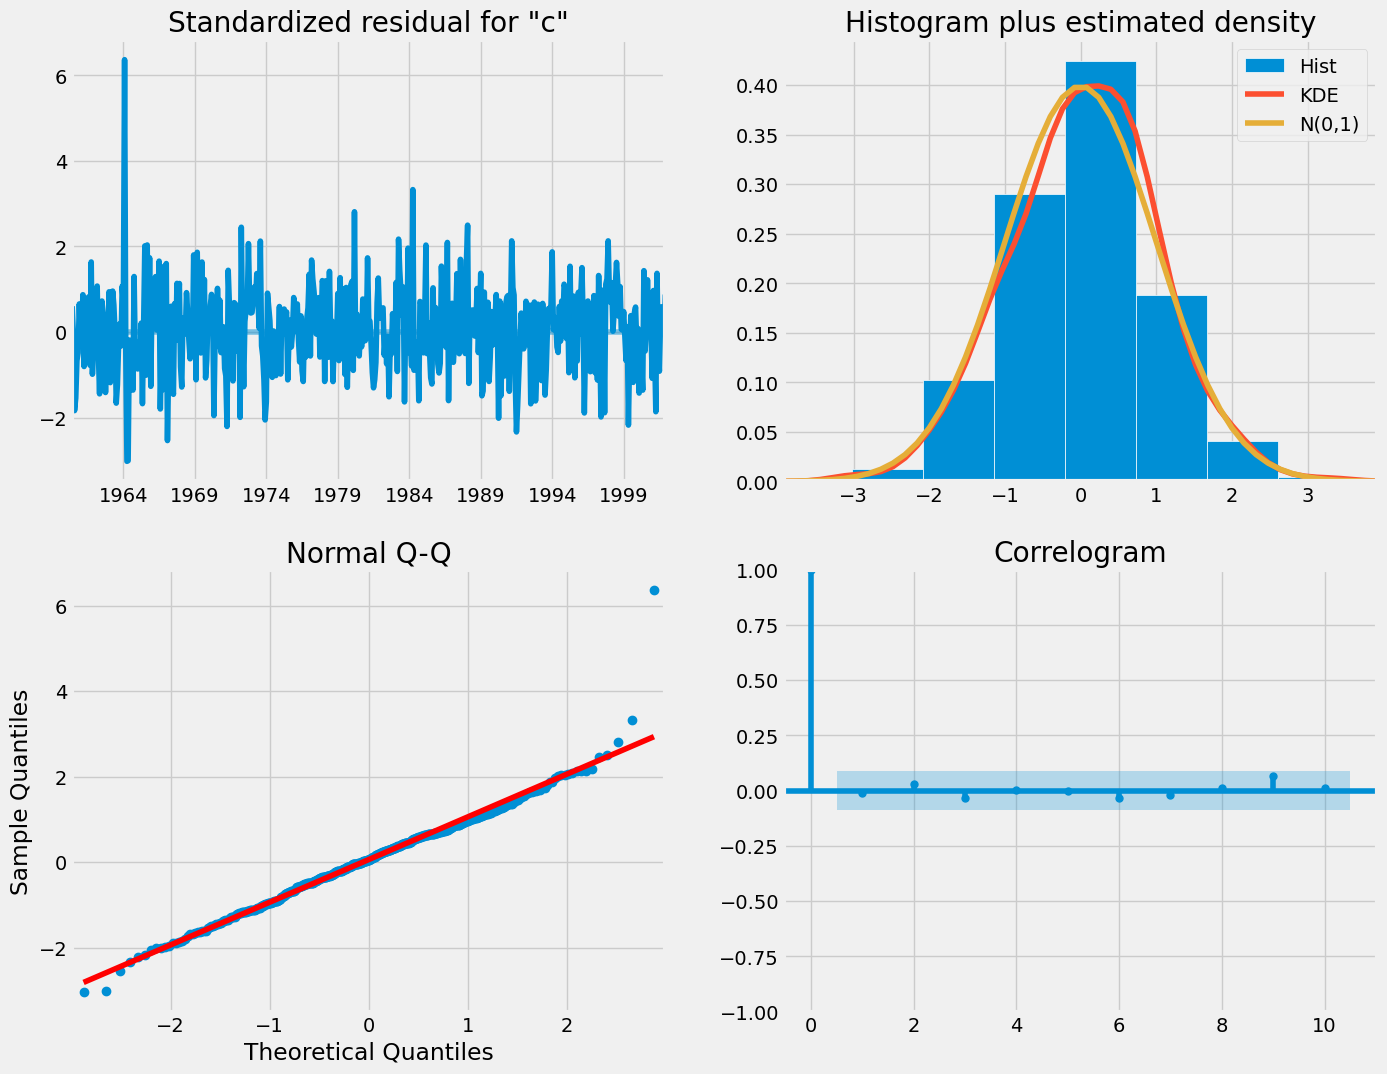

In [12]:
#Evaluate your model
#1. Residuals should be random and unseasonal
#2. Residuals should be normally distributed, or as close to a normal distribution(N(0,1)) as possible
#3. The ordered distribution of residuals should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1)
#4. The residuals should have no correlations with the lagged versions of themselves
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [13]:
###Now that we have a model, we can then produce forecasts
##First compare predicted values to real values of the time series
##We use a one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()  ##Confidence interval

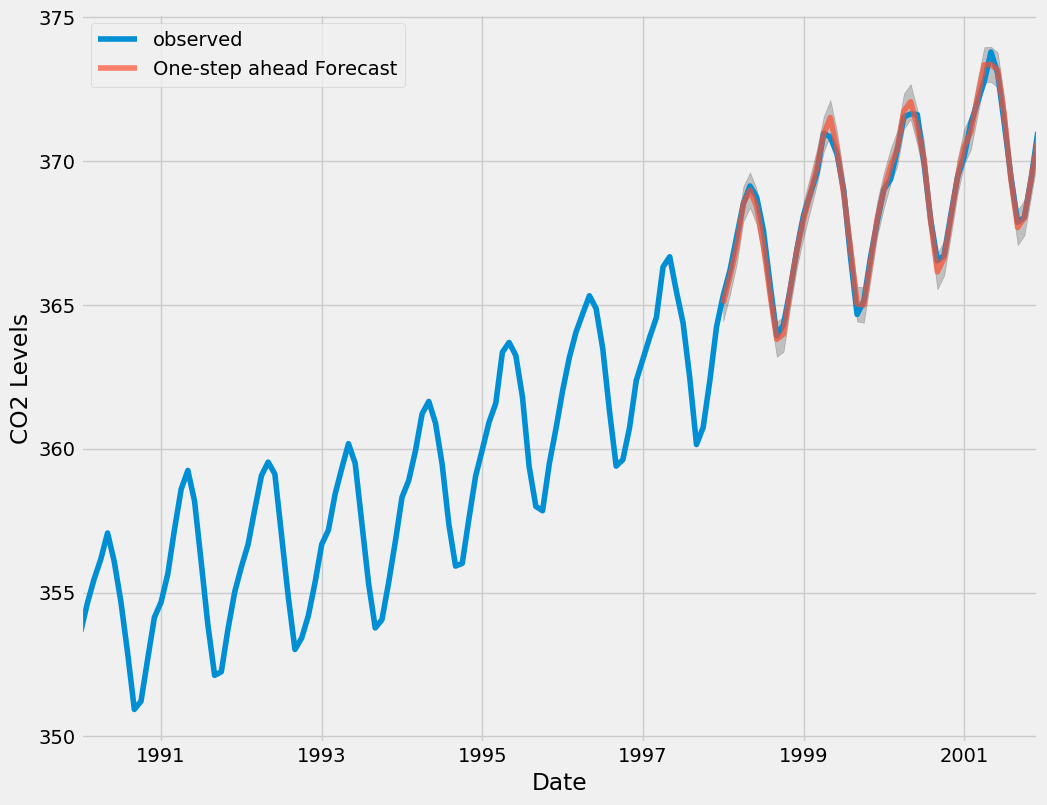

In [14]:
###Now we plot the predictions against the observations 
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

##Fill the area between the prediction and the confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [15]:
###To evaluate our predictive model, determine the mean square error of our predictions
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [16]:
###To better predict with our model, we use dynamic forecasts
##In this case, we only use information from the time series up to a certain point
##After that, forecasts are generated using values from previous forecasted time points
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

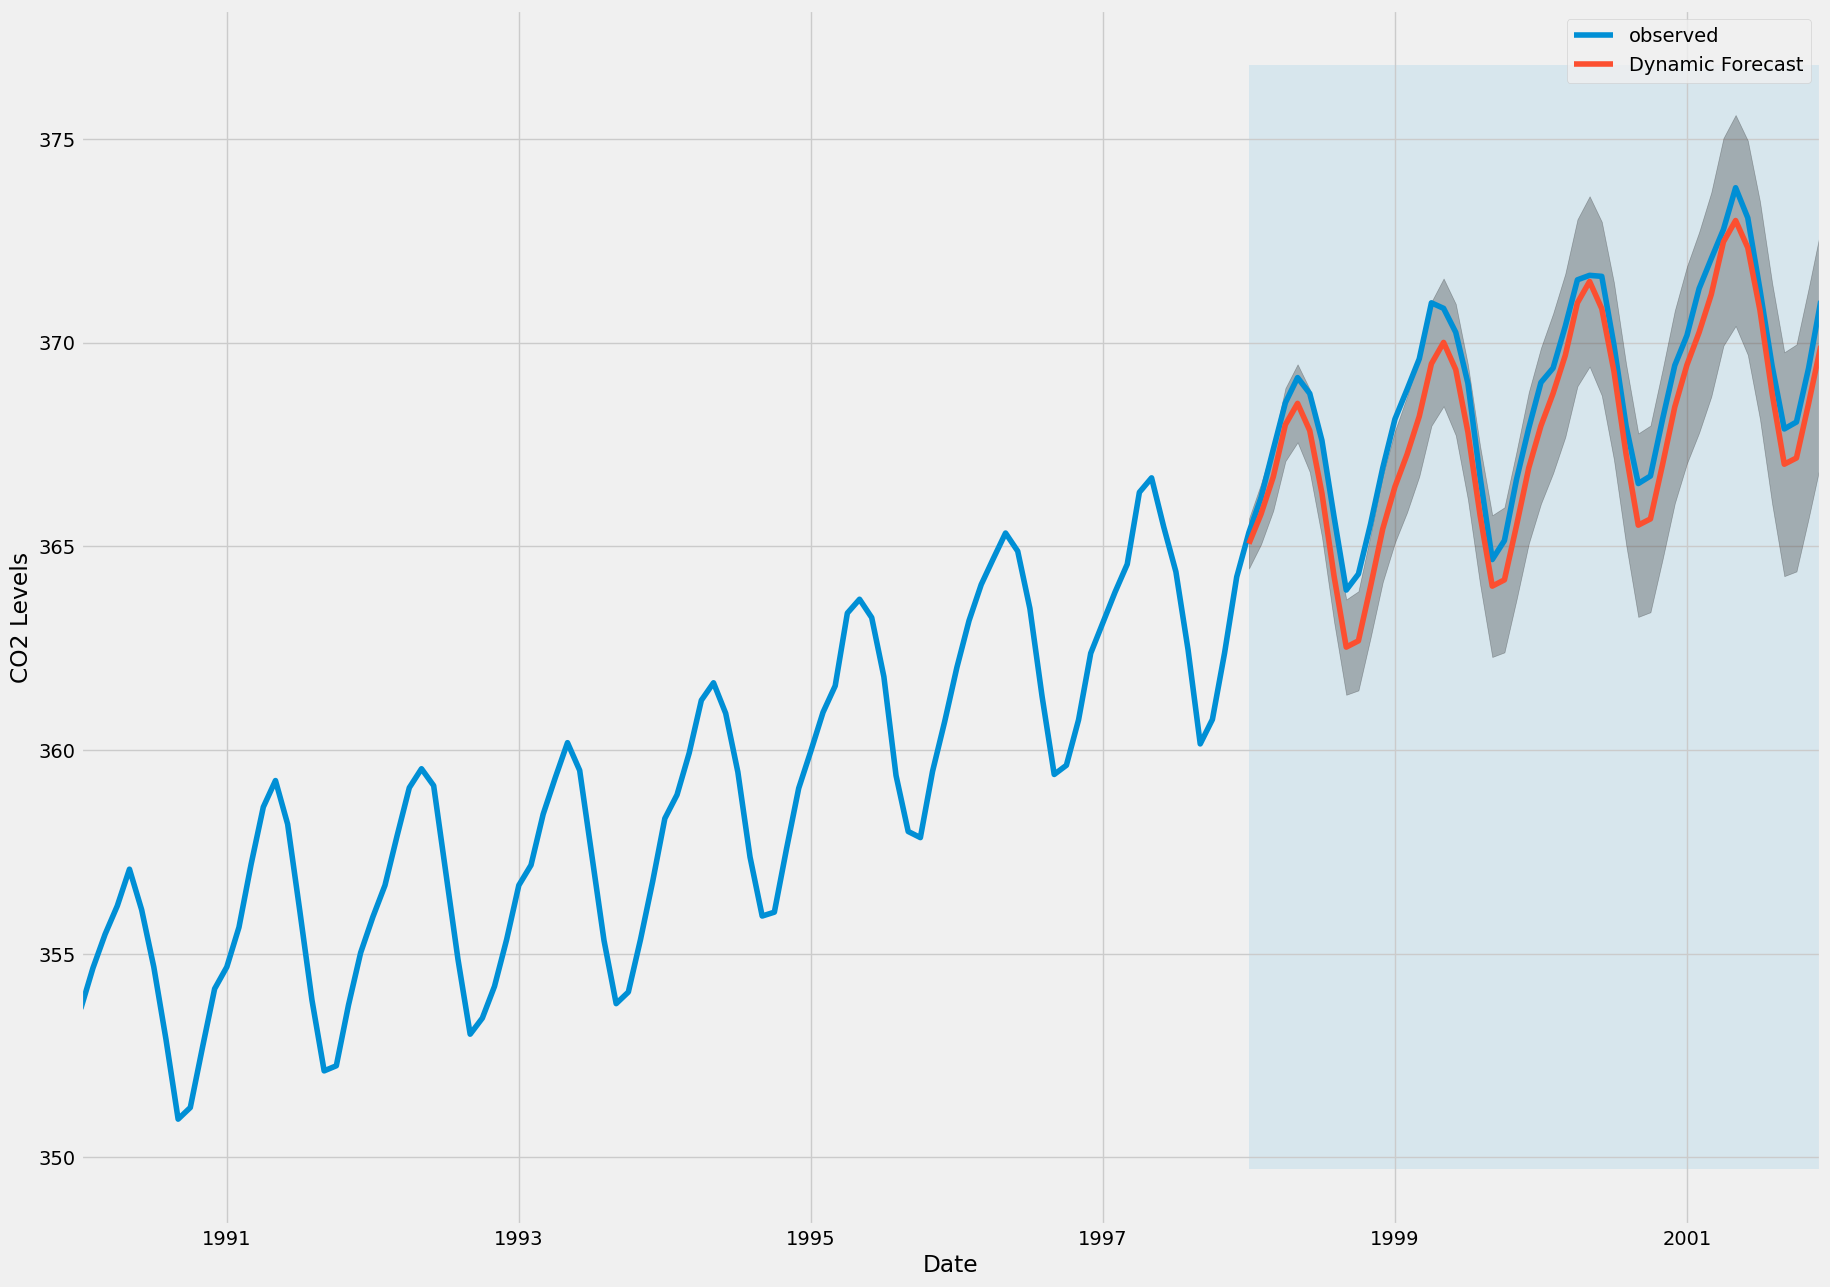

In [17]:
###Now we plot the DYNAMIC predictions against the observations 
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [18]:
###Evaluate our dynamic predictive model using mean square error of our predictions
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [19]:
###Having evaluated our model and found it to be within accuracy limits, we can predict future values of CO2 emmissions
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

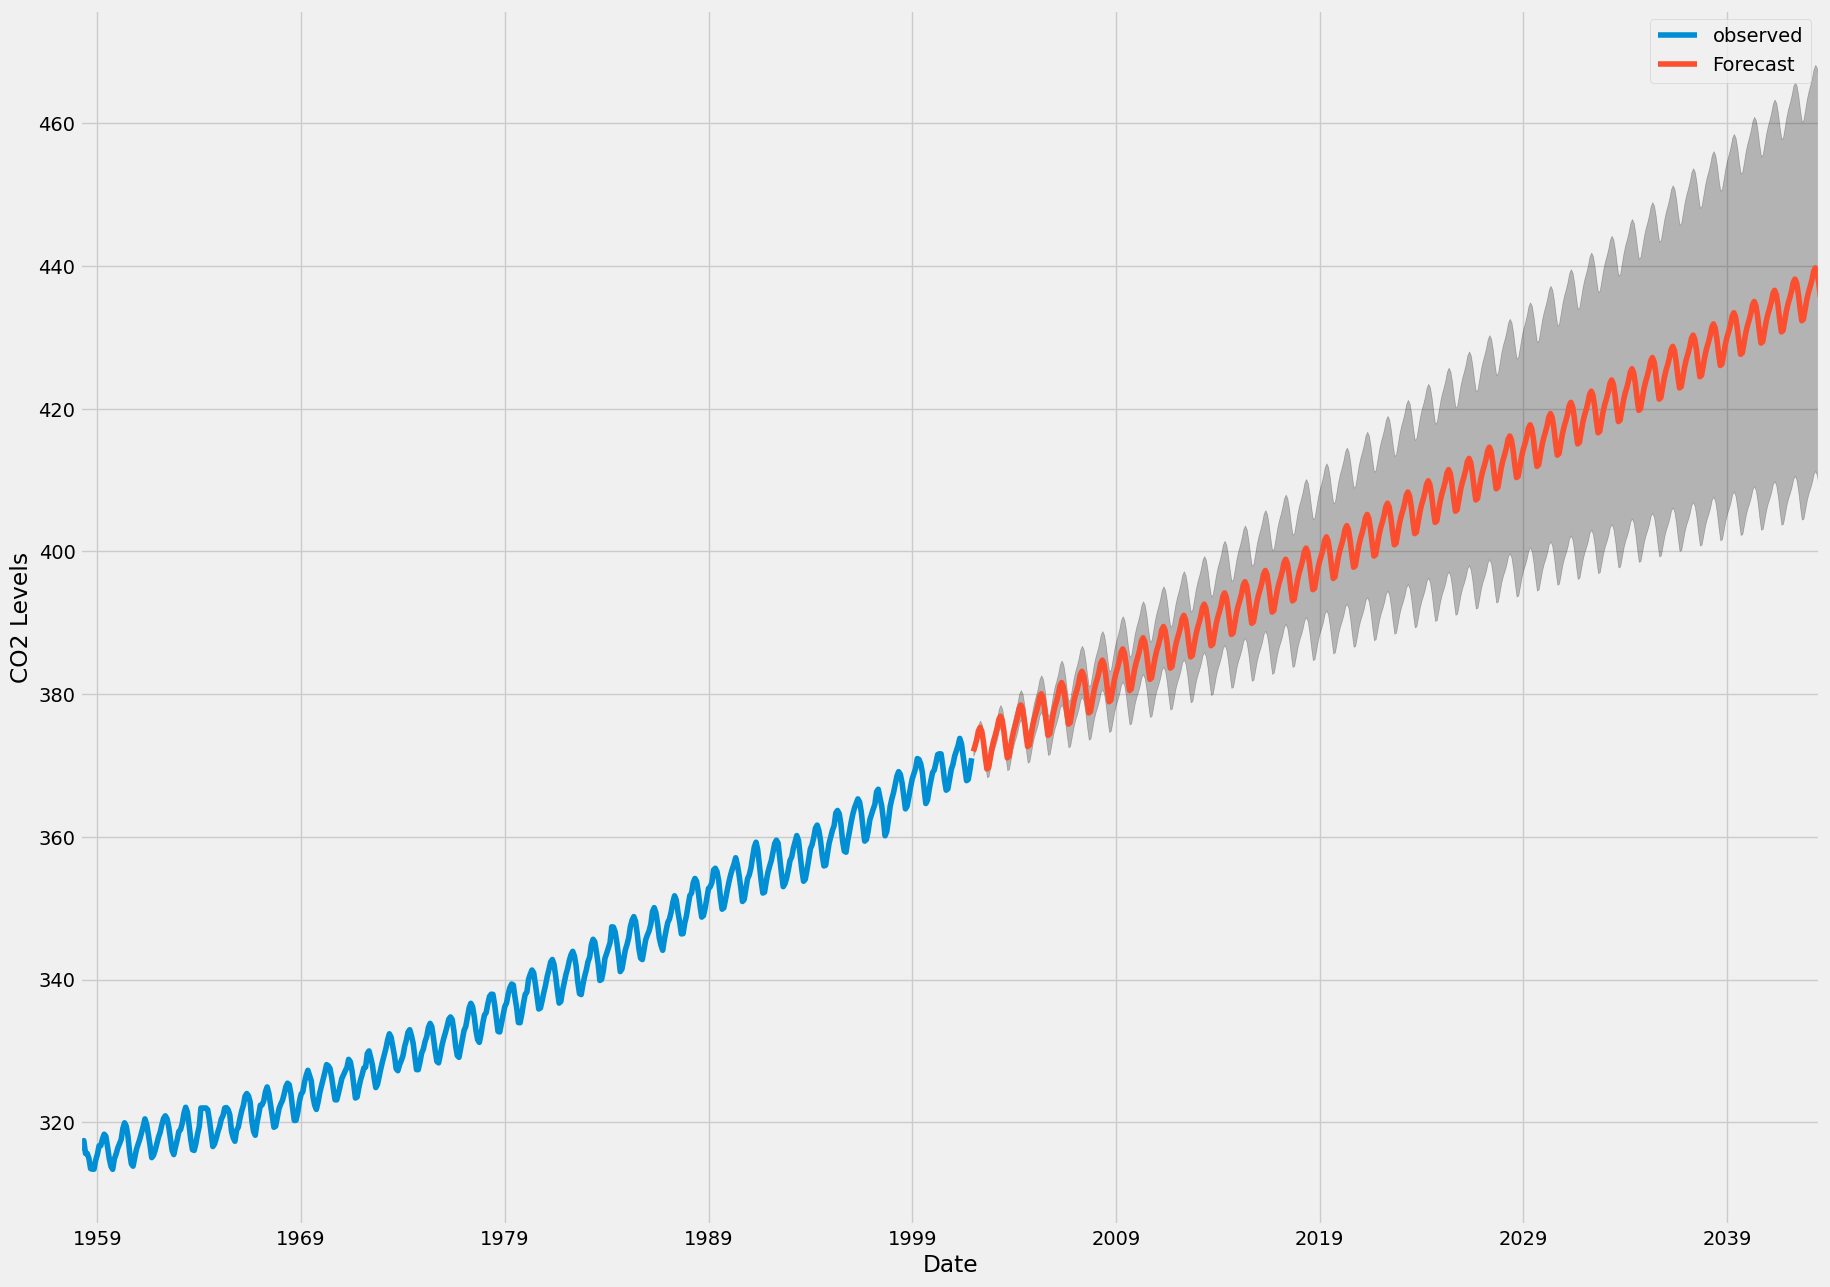

In [20]:
##Plot our forecasted predictions
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [24]:
pred_dynamic_ci

,lower co2,upper co2
1998-01-01,364.453338,365.675220
1998-02-01,365.050166,366.536559
1998-03-01,365.874857,367.529436
1998-04-01,367.090564,368.882769
1998-05-01,367.550534,369.466211
1998-06-01,366.824160,368.854535
1998-07-01,365.234701,367.373246
1998-08-01,363.142977,365.384362
1998-09-01,361.355635,363.695308
1998-10-01,361.462421,363.896405
